In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import time

(1080, 1920)


C:\Users\Cain\AppData\Local\Temp\ipykernel_4156\1457066071.py:21: RuntimeWarning: divide by zero encountered in log
  gaussian_magnitude_spectrum = 20*np.log(np.abs(F_gaussian))
C:\Users\Cain\AppData\Local\Temp\ipykernel_4156\1457066071.py:22: RuntimeWarning: divide by zero encountered in log
  filtered_magnitude_spectrum = 20*np.log(np.abs(F_filtered_img))


This process took 0.9462474000001748 seconds


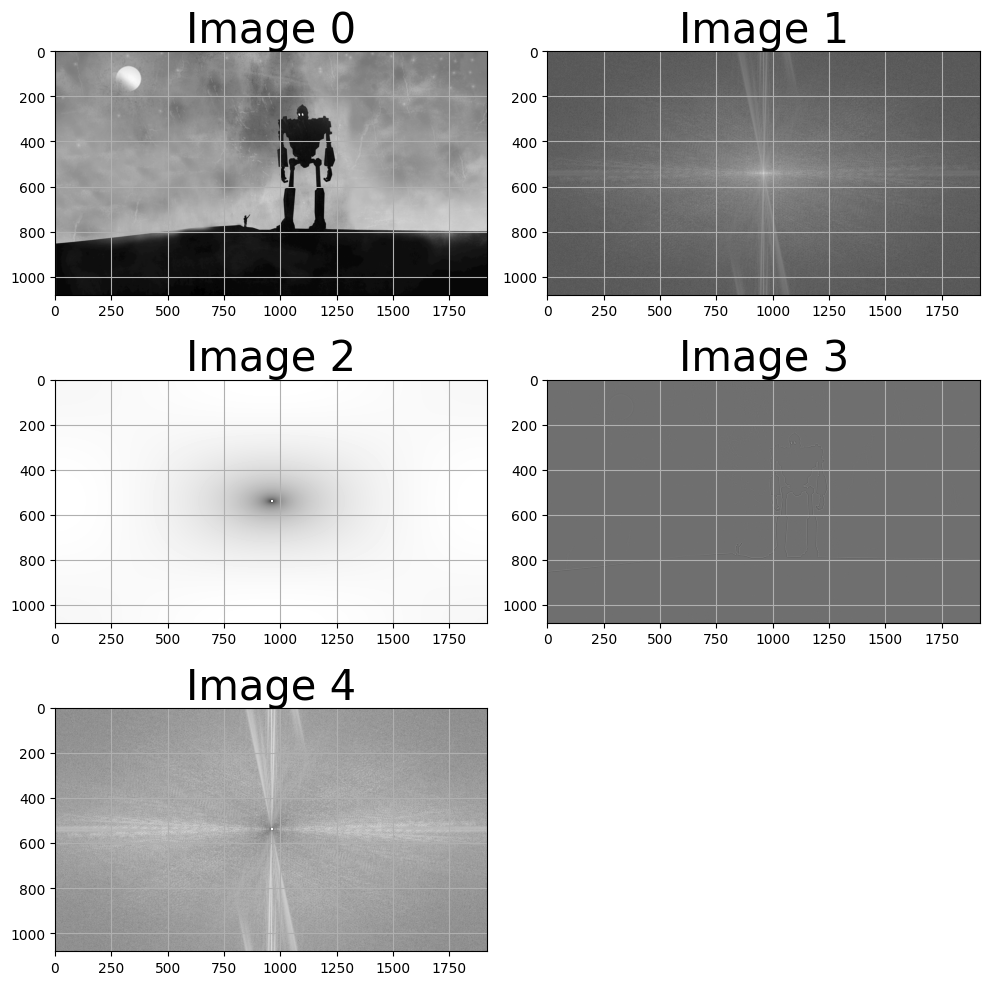

In [40]:


img = cv2.imread('irongiant.png',0)
#img = img[400:600, 1000:1256]
start = time.perf_counter()

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
print(fshift.shape)
magnitude_spectrum = 20*np.log(np.abs(fshift))

gaussian_filter = np.array([[1,1,1],[1,1,1],[1,1,1]])/9
#gaussian_filter = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
edge_filter = np.array([[-1,-1,-1], [-1,8,-1],[-1,-1,-1]])
sharpen_filter = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
#print(gaussian_filter)

g = np.fft.fft2(edge_filter, fshift.shape)
F_gaussian = np.fft.fftshift(g)

F_filtered_img = fshift*F_gaussian

gaussian_magnitude_spectrum = 20*np.log(np.abs(F_gaussian))
filtered_magnitude_spectrum = 20*np.log(np.abs(F_filtered_img))
filtered_img = np.fft.ifft2(np.fft.ifftshift(F_filtered_img)).real
#filtered_img = np.clip(filtered_img, 0, 1)
filtered_img = (filtered_img - np.min(filtered_img))/(np.max(filtered_img)-np.min(filtered_img))

print(f"This process took {time.perf_counter()-start} seconds")

im = Image.fromarray((filtered_img*255).astype(np.uint8))
im.save("your_file.jpeg")



# plt.subplot(121),plt.imshow(img, cmap = 'gray')
# plt.title('Input Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
# plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(filtered_img, cmap = 'gray')
# plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
# plt.show()
list_images = [img, magnitude_spectrum, gaussian_magnitude_spectrum, filtered_img, filtered_magnitude_spectrum]

show_image_list(list_images, figsize=(10, 10))

(1080, 1920)
This process took 61.67624199999955 seconds


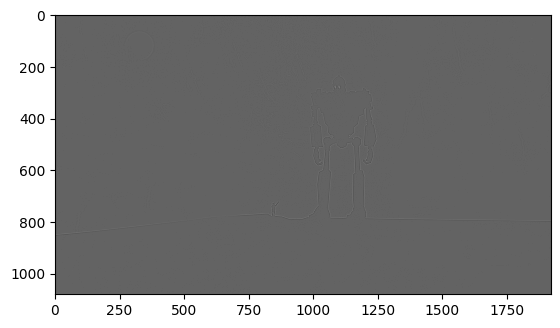

In [41]:
def conv(input, filter):
    output = np.zeros(input.shape)
    for row in range(output.shape[0]): # adjusting for padding and size of filter
        for col in range(output.shape[1]): # adjusting for padding and size of filter
            sum = 0
            for kh in range(filter.shape[0]):
                for kw in range(filter.shape[1]):
                    r = row - filter.shape[0] // 2 + kh
                    c = col - filter.shape[1] // 2 + kw
                    if r >= 0 and c >= 0 and r < output.shape[0] and c < output.shape[1]:
                        sum += input[r][c] * filter[kh][kw]
            output[row][col] = sum
                
    return output.astype(float)


edge_filter = np.asarray([
  [-1, -1, -1],
  [-1,  8, -1],
  [-1, -1, -1]
], dtype=np.float32)


print(img.shape)
start2 = time.perf_counter()
out = conv(img, edge_filter)
out = (out - np.min(out))/(np.max(out)-np.min(out))

print(f"This process took {time.perf_counter()- start2} seconds")

im = Image.fromarray((out*255).astype(np.uint8))
im.save("normal_conv.jpeg")

plt.imshow(out, cmap='gray')



In [42]:
im = Image.fromarray((out*255).astype(np.uint8))
im.save("normal_conv.jpeg")

In [2]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()